# Grabbing processed data

In [1]:
import pyspark.sql.functions as F
import pyspark.sql.types as T
import numpy as np
# need to grab mean and std for each column so that we can normalize the df and apply clustering

joined = spark.read.parquet('./../FINAL_processed_data')
print(joined.printSchema())

columns = joined.columns



# below is for mean, standard deviation based scaling

stats = joined.select(*[[F.mean(c).alias(c+'_mean') for c in joined.columns] + [F.stddev_pop(c).alias(c+'_stddev') for c in joined.columns]]).collect()[0]
# scaling join column for normalization
'''
for column in columns:
    if column != 'Season' and column!= 'record_id':
        joined = joined.withColumn(column,(joined[column]-stats[column+'_mean'])/(stats[column+'_stddev']))
'''


# below is for max, min based scaling
'''stats = joined.select(*[[F.max(c).alias(c+'_max') for c in joined.columns] + [F.min(c).alias(c+'_min') for c in joined.columns]]).collect()[0]
# scaling join column
for column in columns:
    if column != 'Season' and column!='record_id':
        joined = joined.withColumn(column,(joined[column]-stats[column+'_min'])/(stats[column+'_max'] - stats[column+'_min']))'''

print(stats)


print(joined.take(1))




root
 |-- ArrDelay: integer (nullable = true)
 |-- DepDelay: integer (nullable = true)
 |-- ActualElapsedTime: integer (nullable = true)
 |-- Distance: integer (nullable = true)
 |-- origin_lat: double (nullable = true)
 |-- origin_long: double (nullable = true)
 |-- dest_lat: double (nullable = true)
 |-- dest_long: double (nullable = true)
 |-- Season: long (nullable = true)
 |-- origin_prcp: long (nullable = true)
 |-- origin_tmax: long (nullable = true)
 |-- origin_tmin: long (nullable = true)
 |-- origin_awnd: long (nullable = true)
 |-- dest_prcp: long (nullable = true)
 |-- dest_tmax: long (nullable = true)
 |-- dest_tmin: long (nullable = true)
 |-- dest_awnd: long (nullable = true)
 |-- record_id: long (nullable = true)

None
Row(ArrDelay_mean=7.159954113241544, DepDelay_mean=8.155785553305384, ActualElapsedTime_mean=122.11903171401364, Distance_mean=715.1781956065518, origin_lat_mean=37.099659857406145, origin_long_mean=-92.27161607308254, dest_lat_mean=37.09915724198568, des

## Plotting Locations of Clusters from season =0 (winter) and k=9 and 5 representatives per cluster based on elbow plot

In [2]:
season = 1
k = 8
num_reps = 7
fraction = 0.2

In [3]:
if season !=4:
    clusters = spark.read.parquet('./../CURE_Clusters/k='+str(k)+'_season='+str(season)+'_num_reps='+str(num_reps)+'_fraction='+str(fraction))
else:
    # then we want all data
    clusters = spark.read.parquet('./../CURE_Clusters/k='+str(k)+'_season=EVERYTHING'+'_num_reps='+str(num_reps)+'_fraction='+str(fraction))
print(clusters.printSchema())

root
 |-- representative:1: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- representative:2: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- representative:3: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- representative:4: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- representative:5: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- representative:6: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- representative:7: array (nullable = true)
 |    |-- element: double (containsNull = true)

None


In [4]:
# selecting origin latitude and longitude of clusters
# these are the fifth and sixth elements of the records

# locations holds DENORMALIZED (latitude, longitude, cluster_id) tuples for representatives in each cluster
origin_locations = []
destination_locations = []
clusters = clusters.collect()
for i,cluster in enumerate(clusters):
    for representative in cluster:
        denormalized_lat = (representative[4] * stats['origin_lat_stddev']) + stats['origin_lat_mean']
        denormalized_long = (representative[5] * stats['origin_long_stddev']) + stats['origin_long_mean']
        denormalized_dest_lat = (representative[6] * stats['dest_lat_stddev'])+ stats['dest_lat_mean']
        denormalized_dest_long = (representative[7] * stats['dest_long_stddev']) + stats['dest_long_mean']
        origin_locations.append((denormalized_lat,denormalized_long,i))
        destination_locations.append((denormalized_dest_lat,denormalized_dest_long,i))
print(origin_locations)

[(38.69685303436387, -81.59914701316164, 0), (40.44751103436386, -90.68243278916161, 0), (35.04243659436388, -91.60676434116161, 0), (38.65465614636387, -81.28735901316163, 0), (32.45961570636389, -99.89397856516158, 0), (43.67833437036386, -99.71620967716159, 0), (38.04041748236387, -82.45713122916163, 0), (48.39199247398073, -103.90091832560972, 1), (43.87978402598075, -80.19741566160978, 1), (27.35106091398079, -136.21177008560963, 1), (37.45013691398076, -104.60030384560972, 1), (27.35106091398079, -136.21177008560963, 1), (43.87978402598075, -80.19741566160978, 1), (46.20054557798073, -84.44738232560977, 1), (30.91779857776993, -96.17750686513675, 2), (21.684954137769953, -72.70719575313682, 2), (33.864331913769924, -101.36395132913674, 2), (21.684954137769953, -72.70719575313682, 2), (21.603265249769954, -71.88441797713682, 2), (34.96559857776992, -105.19308460913673, 2), (33.680754137769924, -109.51217356913672, 2), (41.97217051385632, -71.39023816397537, 3), (36.20770296185634,

In [5]:
# getting packages we need
import sys
!{sys.executable} -m pip install geopandas
!{sys.executable} -m pip install shapely

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


     latitude   longitude  cluster_id                     geometry
0   38.696853  -81.599147           0   POINT (-81.59915 38.69685)
1   40.447511  -90.682433           0   POINT (-90.68243 40.44751)
2   35.042437  -91.606764           0   POINT (-91.60676 35.04244)
3   38.654656  -81.287359           0   POINT (-81.28736 38.65466)
4   32.459616  -99.893979           0   POINT (-99.89398 32.45962)
5   43.678334  -99.716210           0   POINT (-99.71621 43.67833)
6   38.040417  -82.457131           0   POINT (-82.45713 38.04042)
7   48.391992 -103.900918           1  POINT (-103.90092 48.39199)
8   43.879784  -80.197416           1   POINT (-80.19742 43.87978)
9   27.351061 -136.211770           1  POINT (-136.21177 27.35106)
10  37.450137 -104.600304           1  POINT (-104.60030 37.45014)
11  27.351061 -136.211770           1  POINT (-136.21177 27.35106)
12  43.879784  -80.197416           1   POINT (-80.19742 43.87978)
13  46.200546  -84.447382           1   POINT (-84.44738 46.20

Text(0.5, 1.0, 'Origins of Representatives in Each Cluster ')

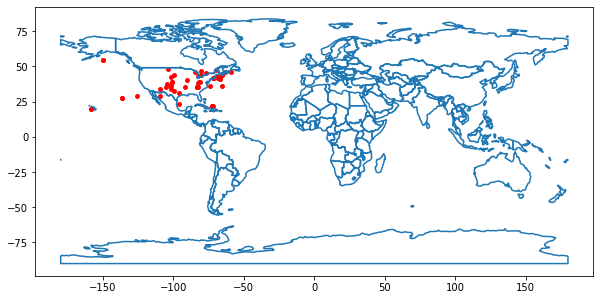

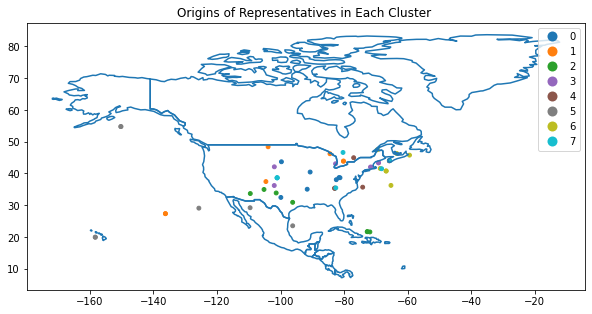

In [6]:
# plotting these latitude longitude values on a map with shapely and geopandas and making a graph for our origin representatives
import pandas as pd
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import matplotlib.pyplot as plt


df = pd.DataFrame(origin_locations, columns =['latitude','longitude','cluster_id'])
#print(df)
geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
gdf = GeoDataFrame(df, geometry=geometry)   
print(gdf)

#this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
north_america = world[world.continent == 'North America']
gdf.plot(ax=world.boundary.plot(figsize=(10, 6)), marker='o', color='red', markersize=15);
gdf.plot(ax=north_america.boundary.plot(figsize=(10, 6)), marker='o', column='cluster_id',categorical=True, markersize=15, legend=True);
plt.title('Origins of Representatives in Each Cluster ')

     latitude   longitude  cluster_id                     geometry
0   40.495038  -85.247554           0   POINT (-85.24755 40.49504)
1   39.726294  -92.585392           0   POINT (-92.58539 39.72629)
2   37.379532  -89.991559           0   POINT (-89.99156 37.37953)
3   37.916481  -91.297328           0   POINT (-91.29733 37.91648)
4   40.034096  -79.065964           0   POINT (-79.06596 40.03410)
5   42.047056  -96.835359           0   POINT (-96.83536 42.04706)
6   37.916481  -91.297328           0   POINT (-91.29733 37.91648)
7   46.200753  -84.449858           1   POINT (-84.44986 46.20075)
8   27.351268 -136.214246           1  POINT (-136.21425 27.35127)
9   42.850313  -69.211248           1   POINT (-69.21125 42.85031)
10  27.351268 -136.214246           1  POINT (-136.21425 27.35127)
11  59.235772 -129.873268           1  POINT (-129.87327 59.23577)
12  36.483160 -103.628045           1  POINT (-103.62805 36.48316)
13  48.392200 -103.903394           1  POINT (-103.90339 48.39

Text(0.5, 1.0, 'Destinations of Representatives In Each Cluster')

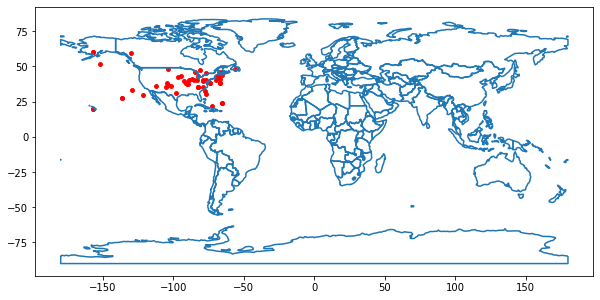

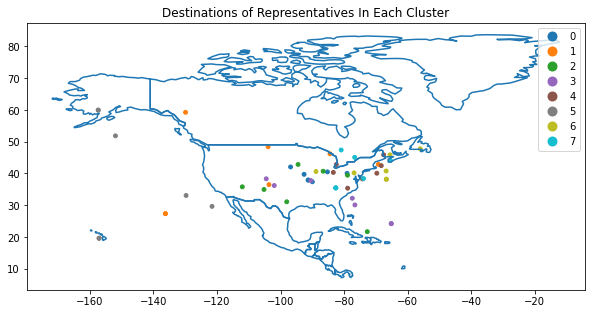

In [7]:
# plotting these latitude longitude values on a map with shapely and geopandas for our destination locations for each representative


df = pd.DataFrame(destination_locations, columns =['latitude','longitude','cluster_id'])
#print(df)
geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
gdf = GeoDataFrame(df, geometry=geometry)   
print(gdf)

#this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
north_america = world[world.continent == 'North America']
gdf.plot(ax=world.boundary.plot(figsize=(10, 6)), marker='o', color='red', markersize=15);

gdf.plot(ax=north_america.boundary.plot(figsize=(10, 6)), marker='o', column='cluster_id',categorical=True, markersize=15, legend=True);

plt.title('Destinations of Representatives In Each Cluster')

## For each cluster, what is the delay distribution of elements within the cluster?

In [8]:
# grabbing mappings for each cluster for this configuration
if season !=4:
    mapping= spark.read.parquet('./../CURE_Mapping/k='+str(k)+'_season='+str(season)+'_num_reps='+str(num_reps)).coalesce(1)
else:
    # then we want all data
    mapping = spark.read.parquet('./../CURE_Mapping/k='+str(k)+'_season=EVERYTHING'+'_num_reps='+str(num_reps)).coalesce(1)
print(mapping.printSchema())

# getting dep delay mean for each cluster in our clustering
# also getting the number of elements in each cluster
# also getting percentages (number of records with delay/all records)
means = []
counts = []
percentages = []
for i in range(len(clusters)):
    if season !=4:
        interested_elements = mapping.where(mapping.tag==i).join(joined.where(joined.Season==season).coalesce(20),'record_id').coalesce(20)
        mean = interested_elements.select(F.mean('DepDelay')).collect()[0]
        num_delay = interested_elements.where(interested_elements.DepDelay>0).count()
    else:
        interested_elements = mapping.where(mapping.tag==i).join(joined.coalesce(20),'record_id').coalesce(20)
        mean = interested_elements.select(F.mean('DepDelay')).collect()[0]
        num_delay = interested_elements.where(interested_elements.DepDelay>0).count()
    print('cluster: '+ str(i)+ ' mean depdelay: ' + str(mean))
    means.append(mean['avg(DepDelay)'])
    count = mapping.where(mapping.tag==i).count()
    counts.append(count)
    percentages.append(num_delay/count)
    print('cluster: ' + str(i) + ' number of examples tagged: ' + str(count))
    print('cluster: ' + str(i) + ' number of records with delay: ' + str(num_delay))
    
    
    
    
# getting the mean dep delay for the population and the total count
if season!=4:
    pop_mean = joined.where(joined.Season==season).select(F.mean('depDelay')).collect()[0]['avg(depDelay)']
    pop_count = joined.where(joined.Season==season).count()
else:
    pop_mean  = joined.select(F.mean('depDelay')).collect()[0]['avg(depDelay)']
    pop_count = joined.count()
print('population_mean: ' + str(pop_mean))
print('population count: ' + str(pop_count))




root
 |-- record_id: long (nullable = true)
 |-- tag: integer (nullable = true)

None
cluster: 0 mean depdelay: Row(avg(DepDelay)=4.60397876154007)
cluster: 0 number of examples tagged: 9595046
cluster: 0 number of records with delay: 3419913
cluster: 1 mean depdelay: Row(avg(DepDelay)=13.058549197539445)
cluster: 1 number of examples tagged: 1661577
cluster: 1 number of records with delay: 775062
cluster: 2 mean depdelay: Row(avg(DepDelay)=4.330077445145995)
cluster: 2 number of examples tagged: 7848652
cluster: 2 number of records with delay: 3026265
cluster: 3 mean depdelay: Row(avg(DepDelay)=6.414543308441341)
cluster: 3 number of examples tagged: 3917458
cluster: 3 number of records with delay: 1696995
cluster: 4 mean depdelay: Row(avg(DepDelay)=44.57390239529503)
cluster: 4 number of examples tagged: 819899
cluster: 4 number of records with delay: 594753
cluster: 5 mean depdelay: Row(avg(DepDelay)=2.7095911825009344)
cluster: 5 number of examples tagged: 353116
cluster: 5 number 

## Plotting percentage of records with a delay per cluster

[]

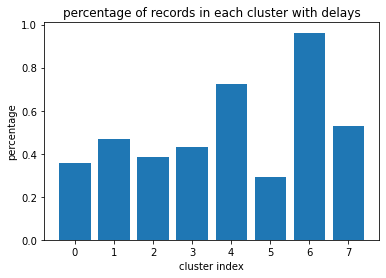

In [9]:
plt.bar([i for i in range(len(percentages))],percentages)
plt.xlabel('cluster index')
plt.ylabel('percentage')
plt.title('percentage of records in each cluster with delays')
plt.plot()

# Plotting number of examples per cluster

[]

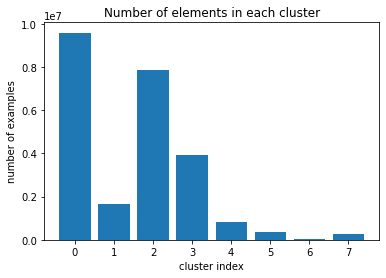

In [10]:
plt.bar([i for i in range(len(counts))],counts)
plt.xlabel('cluster index')
plt.ylabel('number of examples')
plt.title('Number of elements in each cluster')
plt.plot()

## Bar Plot for this Configuration

[]

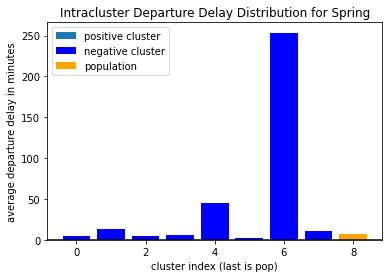

In [11]:

fig = plt.figure()
ax = plt.subplot(111)
positives = []
negatives  = []
for i in range(len(means)):
    if means[i]<0:
        negatives.append((i,means[i]))
    else:
        positives.append((i,means[i]))
#print(zip(*negatives))
first = ax.bar([index for index,value in negatives], [value for index,value in negatives],color='green')
second = ax.bar([index for index,value in positives], [value for index,value in positives],color='blue')
third = ax.bar([len(means)],[pop_mean],color='orange')
ax.axhline(0, color='k')
ax.legend((first,second,third),('positive cluster','negative cluster','population'))
plt.xlabel('cluster index (last is pop)')
plt.ylabel('average departure delay in minutes')
plt.title('Intracluster Departure Delay Distribution for Spring')
plt.plot()

## Cluster analysis for Cluster 6

In [12]:
# intracluster analysis
cluster_index = 6

if season!=4:
    interested_elements = mapping.where(mapping.tag==cluster_index).join(joined.where(joined.Season==season).coalesce(20),'record_id')\
                                                                    .drop('Season','record_id','tag').coalesce(80)
    pop = joined.where(joined.Season==season).drop('Season','record_id')
    pop_stats = pop.select(*[[F.mean(c).alias(c+'_mean') for c in pop.columns] + \
                                     [F.stddev_pop(c).alias(c+'_stddev') for c in pop.columns]]).collect()[0]
else:
    interested_elements = mapping.where(mapping.tag==cluster_index).join(joined,'record_id').drop('Season','record_id','tag').coalesce(20)
    pop_stats = stats

interested_stats = interested_elements\
                                        .select(*[[F.mean(c).alias(c+'_mean') for c in interested_elements.columns] + \
                                        [F.stddev_pop(c).alias(c+'_stddev') for c in interested_elements.columns]]).collect()[0]

print('interested_stats: ' + str(interested_stats))
print('pop_stats: ' + str(pop_stats))

interested_stats: Row(ArrDelay_mean=262.09201327470896, DepDelay_mean=253.4141102744226, ActualElapsedTime_mean=179.60258418827175, Distance_mean=922.6134499081888, origin_lat_mean=37.63672004546157, origin_long_mean=-86.14778934891923, dest_lat_mean=38.06903677605909, dest_long_mean=-89.96307927661537, origin_prcp_mean=106.04122235137548, origin_tmax_mean=199.5807516719732, origin_tmin_mean=94.17319452165563, origin_awnd_mean=49.972389279156346, dest_prcp_mean=72.1091794275703, dest_tmax_mean=190.58823133033474, dest_tmin_mean=84.282205488452, dest_awnd_mean=47.98312023045434, ArrDelay_stddev=149.3122389427367, DepDelay_stddev=200.70127178043666, ActualElapsedTime_stddev=113.93858774942024, Distance_stddev=706.4172198206353, origin_lat_stddev=5.649888779614764, origin_long_stddev=13.58473840080911, dest_lat_stddev=5.2059975376890195, dest_long_stddev=15.866341332682746, origin_prcp_stddev=218.18318309446883, origin_tmax_stddev=93.1012445347207, origin_tmin_stddev=81.93308703211872, or

## Plotting stats compared to average for delay attributes

In [13]:


# defining a function to make plots for us
def plot_features(labels,title,interested_stats,pop_stats):
    fig = plt.figure(figsize=(10,10))
    ax = plt.subplot(111)
    interested_vals = [interested_stats[label+'_mean'] for label in labels]
    interested_stddevs = [interested_stats[label+'_stddev'] for label in labels]
    pop_vals = [pop_stats[label+'_mean'] for label in labels]
    pop_stddevs = [pop_stats[label+'_stddev'] for label in labels]
    indices = np.arange(len(pop_vals))
    width = 0.35
    first = ax.bar(indices,interested_vals,width,label='cluster',yerr=interested_stddevs)
    second = ax.bar(indices+width,pop_vals,width,label='population',yerr=pop_stddevs)
    ax.set_xticks(indices+width/2)
    ax.set_xticklabels(labels)
    plt.ylabel('value')
    plt.xlabel('feature')
    ax.legend((first,second),('Cluster','Population'))
    plt.title(title)
    plt.plot()

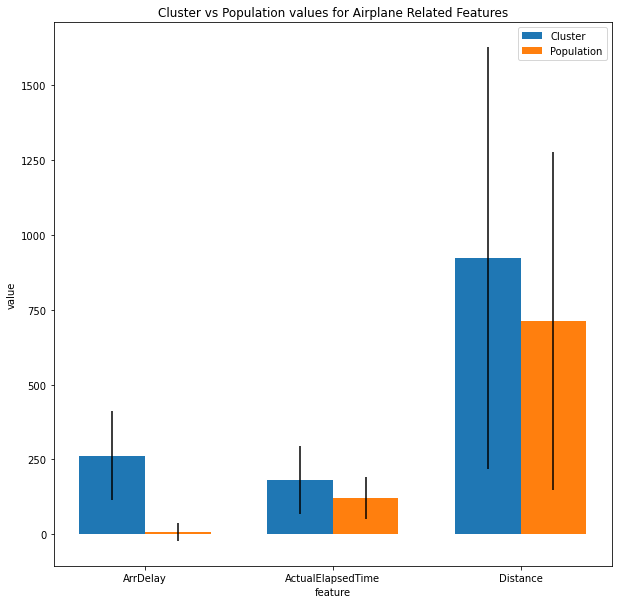

In [14]:
# flight related features
labels = ['ArrDelay', 'ActualElapsedTime', 'Distance']
title = 'Cluster vs Population values for Airplane Related Features'
plot_features(labels,title,interested_stats,pop_stats)

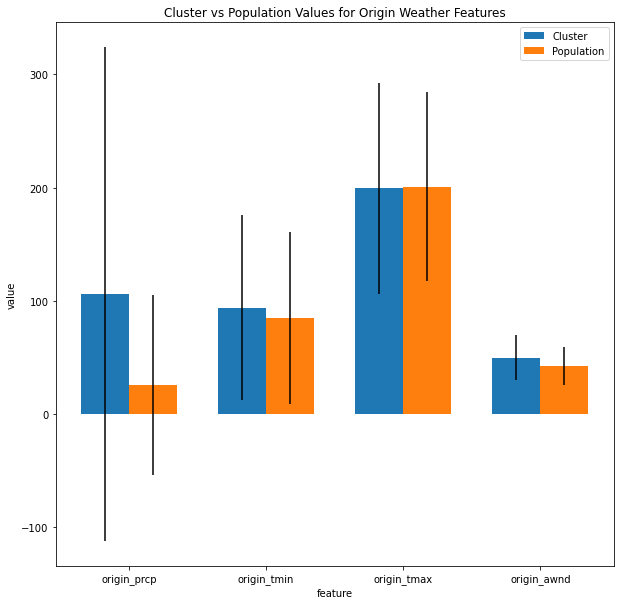

In [15]:
# weather related features for origin
labels = ['origin_prcp','origin_tmin','origin_tmax','origin_awnd']
title = 'Cluster vs Population Values for Origin Weather Features'
plot_features(labels,title,interested_stats,pop_stats)

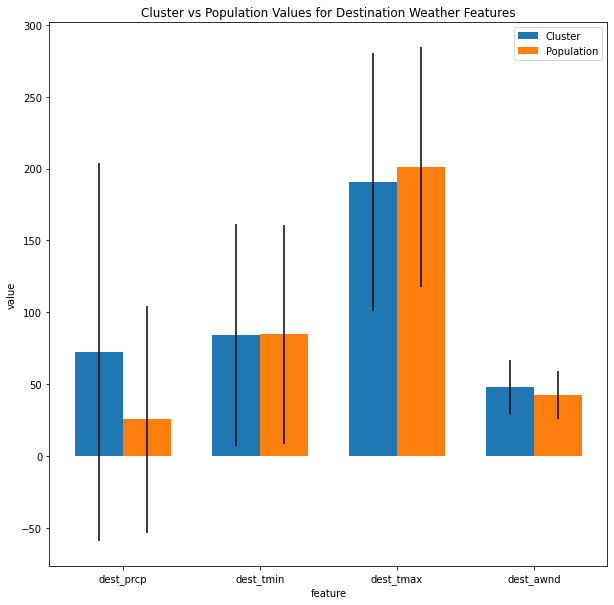

In [16]:
# weather related features for destination
labels = ['dest_prcp','dest_tmin','dest_tmax','dest_awnd']
title = 'Cluster vs Population Values for Destination Weather Features'
plot_features(labels,title,interested_stats,pop_stats)

## These flights have very large departure delays and very large arrival delays. There is a much higher level of precipitation for both the origin and the destination, and slightly average wind speed. These flights are slightly longer than average. Based on the location maps, the flights seems to be domestic flights within the northeastern region and from northeastern to mideast region of the United States.

# Analyzing the other cluster with delays: Cluster 4

In [17]:
# intracluster analysis
cluster_index = 4

if season!=4:
    interested_elements = mapping.where(mapping.tag==cluster_index).join(joined.where(joined.Season==season).coalesce(20),'record_id')\
                                                                    .drop('Season','record_id','tag').coalesce(80)
    
else:
    interested_elements = mapping.where(mapping.tag==cluster_index).join(joined,'record_id').drop('Season','record_id','tag').coalesce(20)
   

interested_stats = interested_elements\
                                        .select(*[[F.mean(c).alias(c+'_mean') for c in interested_elements.columns] + \
                                        [F.stddev_pop(c).alias(c+'_stddev') for c in interested_elements.columns]]).collect()[0]

print('interested_stats: ' + str(interested_stats))
print('pop_stats: ' + str(pop_stats))

interested_stats: Row(ArrDelay_mean=47.12287367102533, DepDelay_mean=44.57390239529503, ActualElapsedTime_mean=104.69660653324372, Distance_mean=523.278611146007, origin_lat_mean=38.45095636832794, origin_long_mean=-84.55626209383672, dest_lat_mean=38.81091783979589, dest_long_mean=-83.45402617899597, origin_prcp_mean=151.2268694070855, origin_tmax_mean=196.13282977537477, origin_tmin_mean=93.02698869007037, origin_awnd_mean=51.1811320662667, dest_prcp_mean=170.0646164954464, dest_tmax_mean=188.34295321740848, dest_tmin_mean=86.8297765944342, dest_awnd_mean=51.532114321398126, ArrDelay_stddev=52.91569943639093, DepDelay_stddev=52.424863280866745, ActualElapsedTime_stddev=44.09576023963794, Distance_stddev=336.1601790546495, origin_lat_stddev=4.400977958789544, origin_long_stddev=10.123780013717708, dest_lat_stddev=4.252150526323279, dest_long_stddev=9.614952254553351, origin_prcp_stddev=190.11626352205195, origin_tmax_stddev=81.3225094338874, origin_tmin_stddev=69.69508771859988, origi

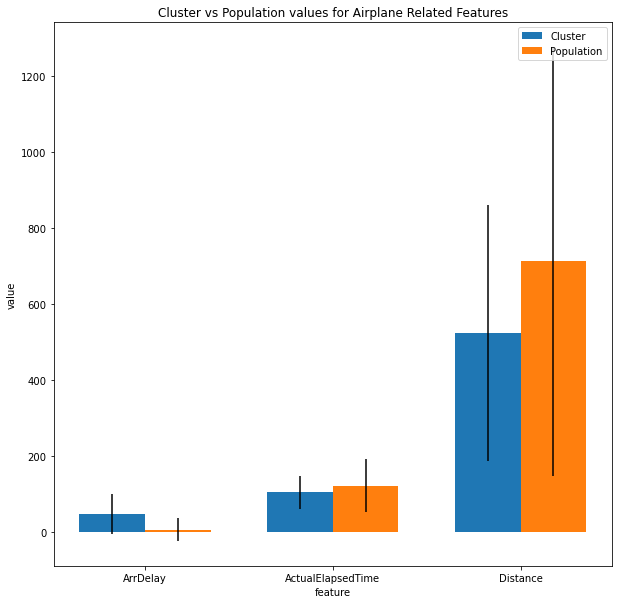

In [18]:
# flight related features
labels = ['ArrDelay', 'ActualElapsedTime', 'Distance']
title = 'Cluster vs Population values for Airplane Related Features'
plot_features(labels,title,interested_stats,pop_stats)

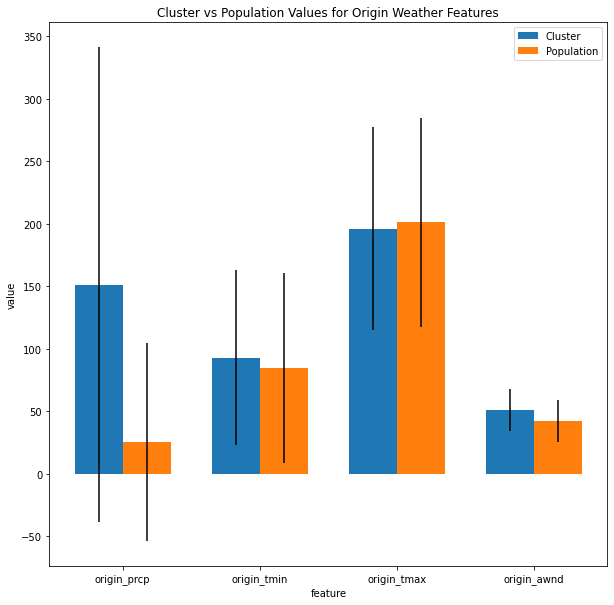

In [19]:
# weather related features for origin
labels = ['origin_prcp','origin_tmin','origin_tmax','origin_awnd']
title = 'Cluster vs Population Values for Origin Weather Features'
plot_features(labels,title,interested_stats,pop_stats)

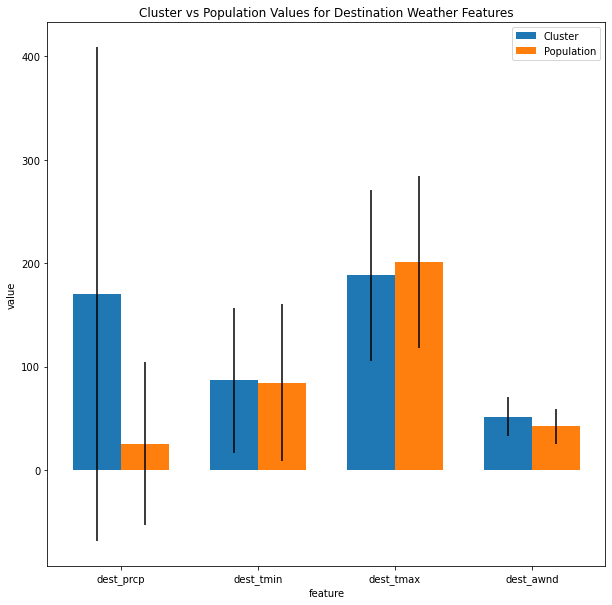

In [20]:
# weather related features for destination
labels = ['dest_prcp','dest_tmin','dest_tmax','dest_awnd']
title = 'Cluster vs Population Values for Destination Weather Features'
plot_features(labels,title,interested_stats,pop_stats)

## This cluster has flights that are shorter than average, but involve a similar region to the last cluster. We see a slightly higher than average windspeed and a much greater amount of precipitation than average.

# Analyzing cluster 5: a cluster with very little average departure delay

In [21]:
# intracluster analysis
cluster_index = 5

if season!=4:
    interested_elements = mapping.where(mapping.tag==cluster_index).join(joined.where(joined.Season==season).coalesce(20),'record_id')\
                                                                    .drop('Season','record_id','tag').coalesce(80)
    
else:
    interested_elements = mapping.where(mapping.tag==cluster_index).join(joined,'record_id').drop('Season','record_id','tag').coalesce(20)


interested_stats = interested_elements\
                                        .select(*[[F.mean(c).alias(c+'_mean') for c in interested_elements.columns] + \
                                        [F.stddev_pop(c).alias(c+'_stddev') for c in interested_elements.columns]]).collect()[0]

print('interested_stats: ' + str(interested_stats))
print('pop_stats: ' + str(pop_stats))

interested_stats: Row(ArrDelay_mean=-1.0181300195969596, DepDelay_mean=2.7095911825009344, ActualElapsedTime_mean=132.79821928204896, Distance_mean=852.176726628077, origin_lat_mean=36.31865982461713, origin_long_mean=-125.82359212550861, dest_lat_mean=37.103431326694576, dest_long_mean=-136.2555545328549, origin_prcp_mean=47.62111600720443, origin_tmax_mean=193.34374256618221, origin_tmin_mean=92.67985024751073, origin_awnd_mean=35.62492778577011, dest_prcp_mean=8.33420745590684, dest_tmax_mean=188.12859513587603, dest_tmin_mean=87.17582324222069, dest_awnd_mean=36.467724487137374, ArrDelay_stddev=20.26435036864388, DepDelay_stddev=17.2216545657629, ActualElapsedTime_stddev=105.50606562928647, Distance_stddev=840.2298037000293, origin_lat_stddev=13.807031223665705, origin_long_stddev=26.73853138285869, dest_lat_stddev=14.878755661134136, dest_long_stddev=21.23390933623217, origin_prcp_stddev=107.91761707478003, origin_tmax_stddev=102.10344496218737, origin_tmin_stddev=108.873909862313

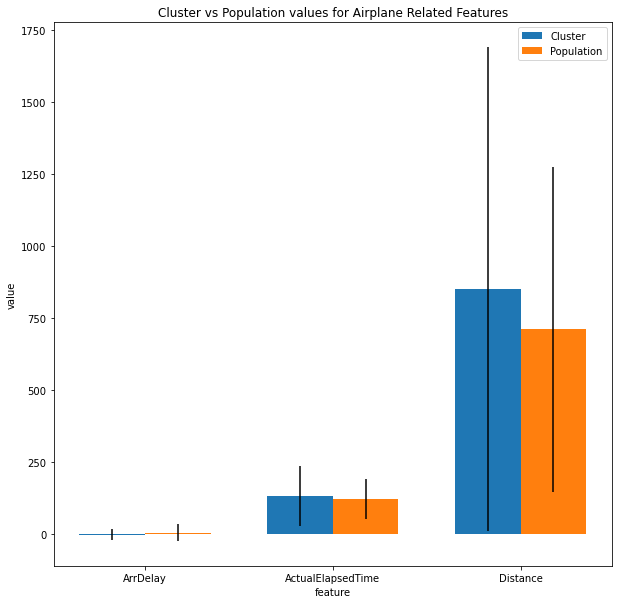

In [22]:
# flight related features
labels = ['ArrDelay', 'ActualElapsedTime', 'Distance']
title = 'Cluster vs Population values for Airplane Related Features'
plot_features(labels,title,interested_stats,pop_stats)

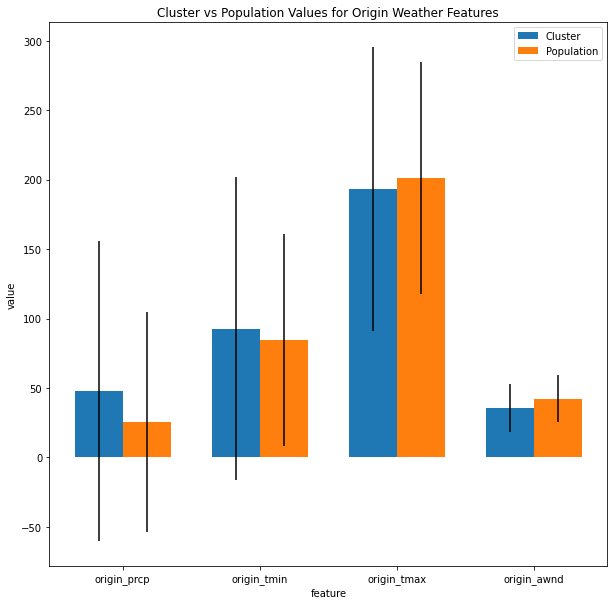

In [23]:
# weather related features for origin
labels = ['origin_prcp','origin_tmin','origin_tmax','origin_awnd']
title = 'Cluster vs Population Values for Origin Weather Features'
plot_features(labels,title,interested_stats,pop_stats)

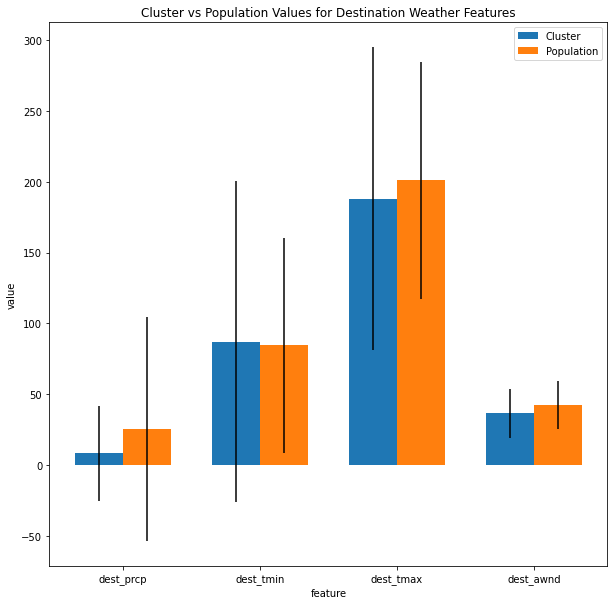

In [24]:
# weather related features for destination
labels = ['dest_prcp','dest_tmin','dest_tmax','dest_awnd']
title = 'Cluster vs Population Values for Destination Weather Features'
plot_features(labels,title,interested_stats,pop_stats)

## This is a cluster with longer than average flights, but very little delay in comparison. We see that these flights have very little arrival delay, very little precipitation. In addition, average windspeed is lower than the population. Interestingly, these flights seem to involve the southern regions of the US and the outskirts: Hawaii and Alaska. 